Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  #print(statinfo.st_size)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 33195930)#31344016

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]] # [word, count] list
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary) # store: word -> index
  data = list() # indexes of words
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count # update 'UNK' count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) # store: index -> word
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5238, 3081, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0
# [8, 2, 1] as the example
# [8, 4, 2]
def generate_batch(batch_size, num_skips, skip_window):
  global data_index # modify global data_index value. For synchronization purpose?
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window # generate an exception when not fulfilled.
  batch = np.ndarray(shape=(batch_size), dtype=np.int32) # len = 8, row list
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32) # len = 8, column list
  span = 2 * skip_window + 1 # [ skip_window target skip_window ] # 3
  buffer = collections.deque(maxlen=span)
  for _ in range(span): # insert the first k words, k = span
    buffer.append(data[data_index]) 
    data_index = (data_index + 1) % len(data) # 1
  for i in range(batch_size // num_skips): # 8/2 = 4
    target = skip_window  # target label at the center of the buffer, 1
    targets_to_avoid = [ skip_window ] # 1
    for j in range(num_skips):   # 2 ｛0,1｝
      while target in targets_to_avoid:
        target = random.randint(0, span - 1) # random value between [0, 3) {0, 1, 2}
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'term', 'originated', 'a', 'of', 'originated', 'as', 'term']


Train a skip-gram model.

In [6]:
batch_size = 128 # batch size is big
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size]) # array of words []
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])# array of center words
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) # [50000, 128]
  softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], # [50000, 128], 1/sqrt(128)
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size])) # 50000
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))
  # sampled_softmax_loss: faster way to train a softmax classifier over a huge number of classes.
  # similar to tf.nn.softmax(tf.matmul(inputs, weights) + biases)

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True)) # calculate the sum of columns
  normalized_embeddings = embeddings / norm # normalize embeddings
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset) # find embedding of validation word
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) 

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels} #
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size): #xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k): #xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.859502
Nearest to up: botvinnik, wcw, herbalists, semester, nieve, fed, abstain, polysaccharides,
Nearest to was: wane, nagy, provider, multilingual, hezekiah, jorge, imine, stretcher,
Nearest to more: susceptibility, damn, propane, ibadi, rural, hal, patriot, castello,
Nearest to see: founded, schwarzenegger, destitute, galloway, chat, scholasticus, wiktionary, hood,
Nearest to all: harpers, portions, shoulders, sindhu, perpetuate, tertium, forth, baked,
Nearest to it: abramovich, neri, fraser, malvern, firepower, obverse, puddle, mathematische,
Nearest to american: brigham, marketed, motilal, ets, pulmonic, wondered, grimes, glasgow,
Nearest to some: warmest, marmite, estudios, pine, poets, katha, body, dyadic,
Nearest to an: lamm, biya, suvs, static, singled, hide, mentions, ending,
Nearest to between: broncos, maecenas, transformed, determines, intruder, baptize, steyr, jahan,
Nearest to during: metaxas, outsiders, extinguisher, christ, kaufman

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

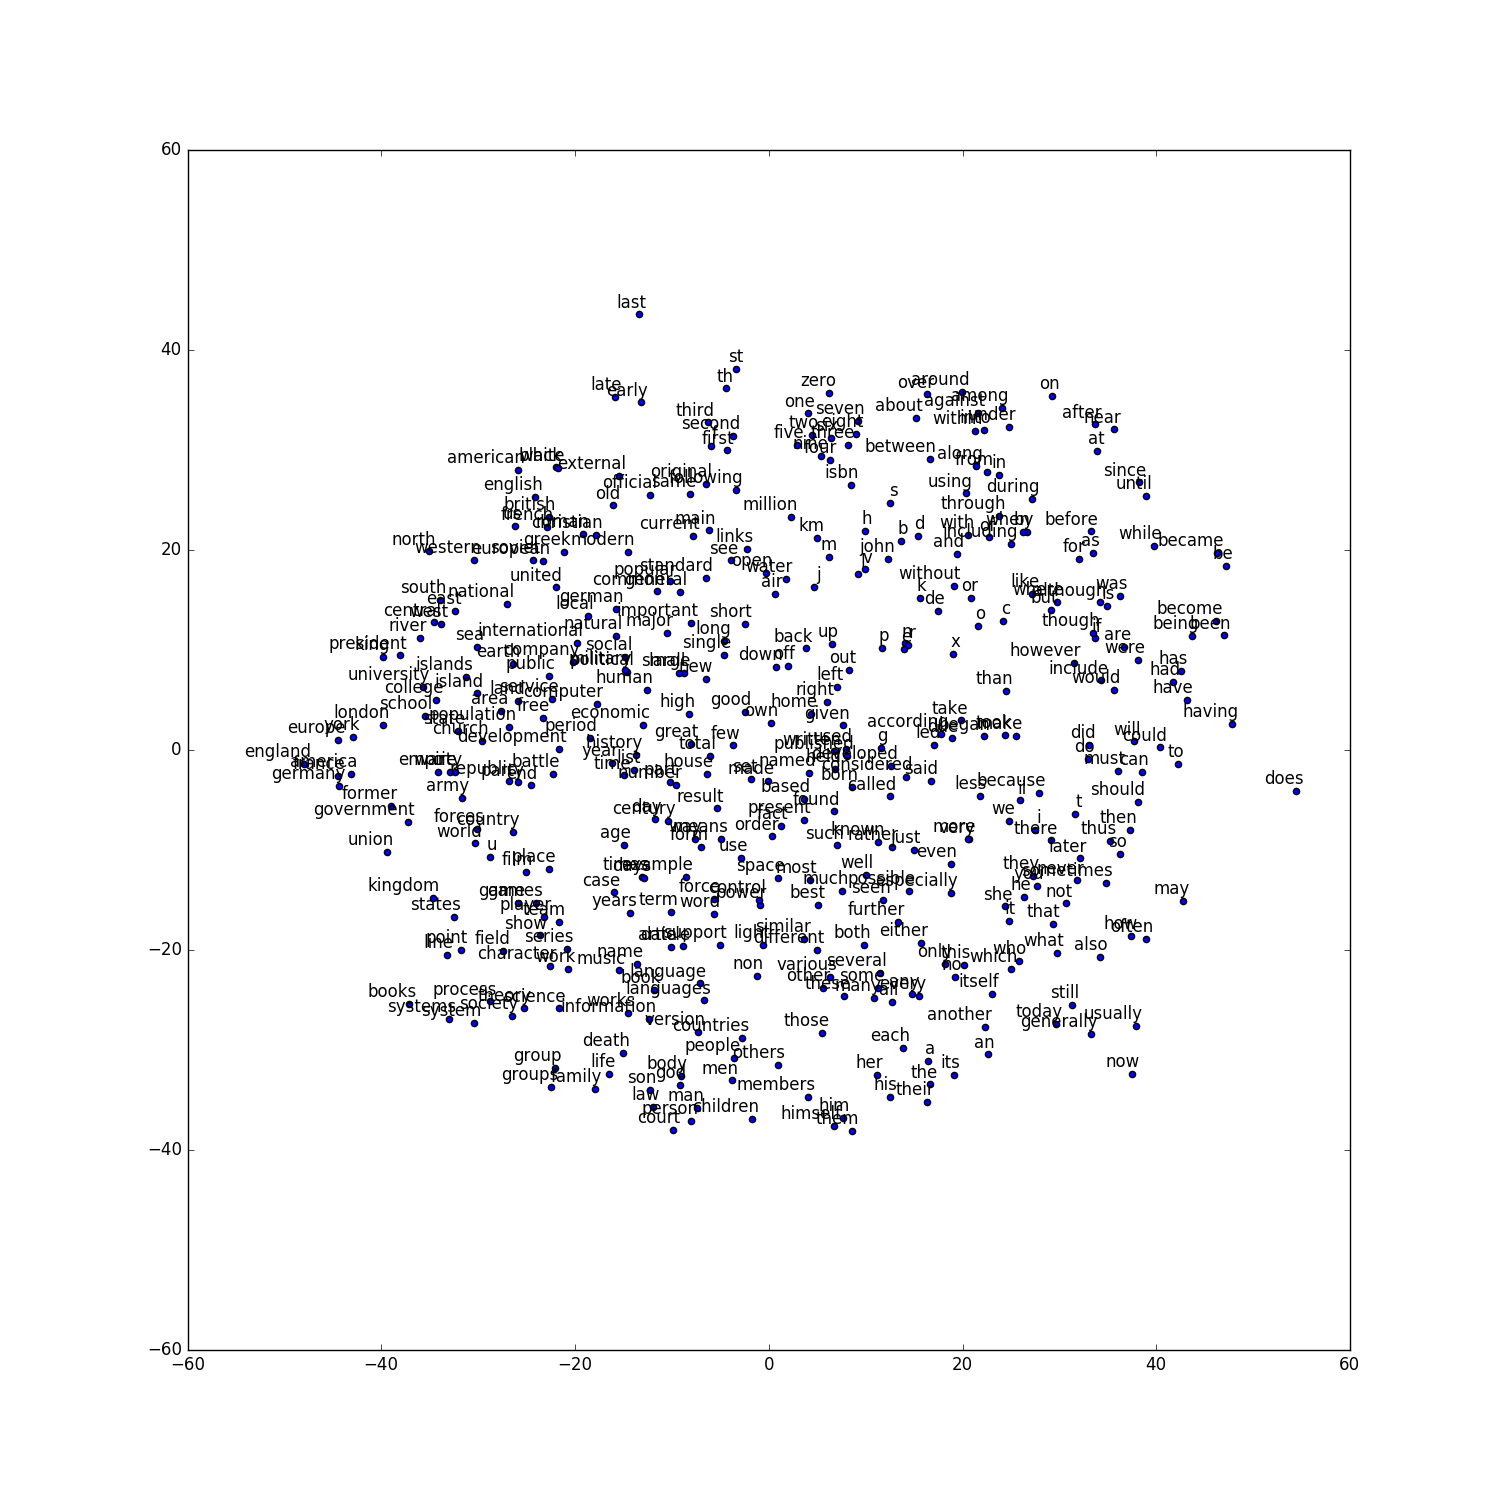

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.savefig('fig_plot.png')
  #pylab.show()
  

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

from IPython.display import display, Image
display(Image('fig_plot.png'))

---

Problem
-------

An alternative to Word2Vec is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [8]:
data_index = 0
# [8, 2, 1] as the example
# [8, 4, 2]
def generate_batch(batch_size, num_cbow, cbow_window, cbow_len):
  global data_index # modify global data_index value. For synchronization purpose?
  assert batch_size % num_cbow == 0
  assert num_cbow <= 2 * (cbow_window + 1) - cbow_len # generate an exception when not fulfilled.
  assert cbow_window >= cbow_len
  batch = np.ndarray(shape=(batch_size), dtype=np.int32) # len = 8, row list
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32) # len = 8, column list
  span = 2 * (cbow_window + 1) - cbow_len
  buffer = collections.deque(maxlen=span)
  for _ in range(span): # insert the first k words, k = span
    buffer.append(' '.join(str(data[data_index: (data_index + cbow_len)]))) 
    #print(data_index)
    data_index = (data_index + 1) % len(data) # 1
  counter = 0
  for i in range(batch_size // num_cbow): # 8/2 = 4
    target = cbow_window  # target label at the center of the buffer, 1
    targets_to_avoid = [ cbow_window ] # 1 cbow_window +/- length
    for j in range(cbow_len):
      targets_to_avoid.append(cbow_window - cbow_len + j + 1)
    for j in range(num_cbow):   # 2 ｛0,1｝
      while target in targets_to_avoid:
        target = random.randint(0, span - 1) # random value between [0, 3) {0, 1, 2}
      targets_to_avoid.append(target)
      batch[i * num_cbow + j] = buffer[cbow_window]
      labels[i * num_cbow + j, 0] = buffer[target]
    buffer.append(' '.join(str(data[data_index: (data_index + cbow_len)])))
    data_index = (data_index + 1) % len(data)
    counter += 1
    if counter == 3:
        return batch, labels
  return batch, labels 

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_cbow, cbow_window, cbow_len in [(2, 1, 1)]: #, (4, 2, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_cbow=num_cbow, cbow_window=cbow_window, cbow_len=cbow_len)
    print('\nwith num_cbow = %d, cbow_window = %d, and cbow_len = %d:' % (num_cbow, cbow_window, cbow_len))
#    print('    batch:', [reverse_dictionary[bi] for bi in batch])
#    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']


ValueError: invalid literal for int() with base 10: '[ 3 0 8 1 ]'